/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
768/768 ━━━━━━━━━━━━━━━━━━━━ 50s 62ms/step - accuracy: 0.6429 - loss: 1.4469 - val_accuracy: 0.5673 - val_loss: 2.1588
Epoch 2/100
768/768 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.8717 - loss: 0.6035 - val_accuracy: 0.4996 - val_loss: 2.5116
Epoch 3/100
768/768 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - accuracy: 0.8923 - loss: 0.4853 - val_accuracy: 0.5140 - val_loss: 2.3072
Epoch 4/100
768/768 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.9066 - loss: 0.4220 - val_accuracy: 0.5414 - val_loss: 2.6086
Epoch 5/100
768/768 ━━━━━━━━━━━━━━━━━━━━ 53s 69ms/step - accuracy: 0.9147 - loss: 0.3725 - val_accuracy: 0.5368 - val_loss: 2.5717
Epoch 6/100
768/768 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.9258 - loss: 0.3306 - val_accuracy: 0.5306 - val_loss: 2.3223
Epoch 7/100
768/768 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.9255 - loss: 0.3156 - val_accuracy: 0.5183 - val_loss: 2.7069
Epoch 8/100
768/768 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.9291 - loss: 0

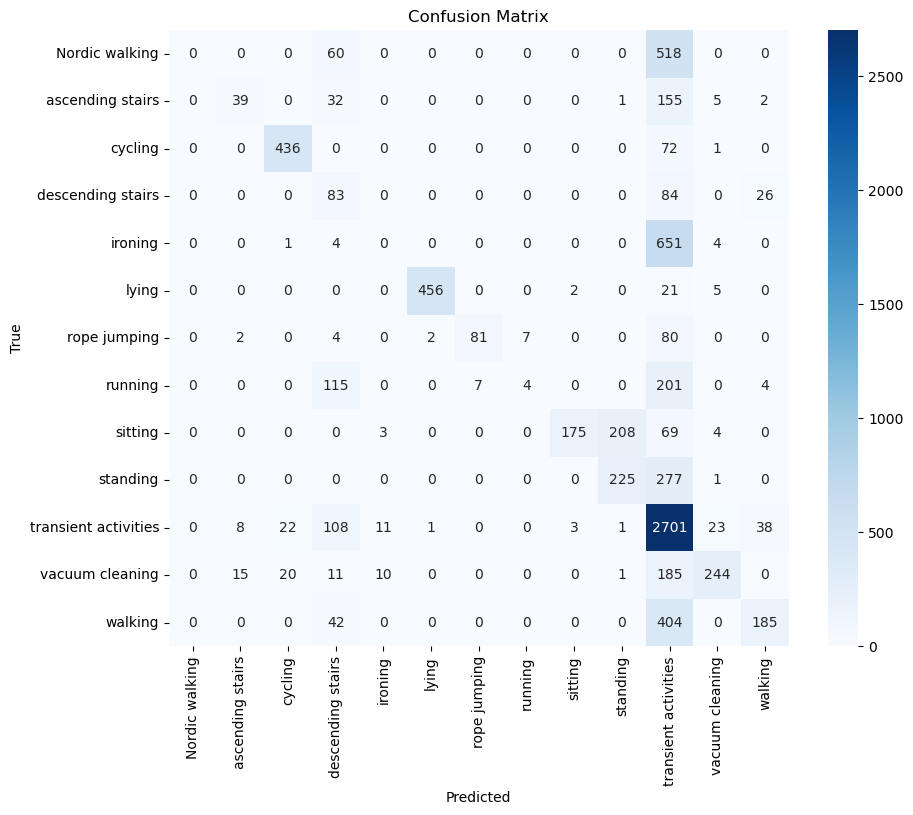

                      precision    recall  f1-score   support

      Nordic walking       0.00      0.00      0.00       578
    ascending stairs       0.61      0.17      0.26       234
             cycling       0.91      0.86      0.88       509
   descending stairs       0.18      0.43      0.25       193
             ironing       0.00      0.00      0.00       660
               lying       0.99      0.94      0.97       484
        rope jumping       0.92      0.46      0.61       176
             running       0.36      0.01      0.02       331
             sitting       0.97      0.38      0.55       459
            standing       0.52      0.45      0.48       503
transient activities       0.50      0.93      0.65      2916
     vacuum cleaning       0.85      0.50      0.63       486
             walking       0.73      0.29      0.42       631

            accuracy                           0.57      8160
           macro avg       0.58      0.42      0.44      8160
      

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'PeopleId']  
df_train = df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns])
df_test = df_test.drop(columns=[col for col in columns_to_drop if col in df_test.columns])

# Handle missing values
df_train = df_train.dropna()
df_test = df_test.dropna()

# Separate features and target
train_features = df_train.drop(columns=['activityID'])
train_labels = df_train['activityID']

test_features = df_test.drop(columns=['activityID'])
test_labels = df_test['activityID']

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convert labels to categorical
train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# Normalize features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Sequence preparation
timesteps = 50  # Shorter sequences for better alignment with data characteristics
num_features = train_features_scaled.shape[1]

def create_sequences(features, labels, timesteps):
    X, y = [], []
    for i in range(0, len(features) - timesteps, timesteps):
        X.append(features[i:i + timesteps])
        y.append(labels[i + timesteps - 1])  # Last label in the sequence
    return np.array(X), np.array(y)

# Create sequences for train and test sets
X_train, y_train = create_sequences(train_features_scaled, train_labels_categorical, timesteps)
X_test, y_test = create_sequences(test_features_scaled, test_labels_categorical, timesteps)

# Define the LSTM model with fine-tuned parameters
model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features), return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.4),  # Increased Dropout
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Additional dense layer for better representation
    Dense(y_train.shape[1], activation='softmax')  # Number of classes
])

# Compile the model with a reduced learning rate
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=64, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(class_report)
